# Dataviz

## Data generation process

`final_train_data.csv` was generated by running the pipeline up to the `feature_generation` stage on the longest test-train split, then explorting `pipeline.train_sets[0]` to csv (i.e. the training data representing licenses from 2002-2016 with labels constructed from 2017-2018 data). This is the file loaded below.

In [96]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Tweak display settings for tables
pd.options.display.max_columns = 999

In [74]:
# Read data
DATA_PATH = "../../data/Business_Licenses.csv"
DTYPE_DICT = {
    'ZIP CODE': str,
    'BUSINESS ACTIVITY ID': str,
    'BUSINESS ACTIVITY': str,
}
DATE_COLS = ['LICENSE TERM EXPIRATION DATE', 'DATE ISSUED']

df = pd.read_csv(DATA_PATH,
                 dtype=DTYPE_DICT,
                 parse_dates=DATE_COLS)

# Simple processing
df['YEAR'] = df["DATE ISSUED"].dt.year.astype('int')
df = df.loc[df['YEAR'] < 2019]

df.shape

(957632, 35)

## Import useful functions

In [103]:
def get_locations(input_df):
    '''
    Takes license-level data and returns a dataframe with location attributes
        for each account-site.

    Input:  input_df - license-level data with specified location columns.
    Output: df - unique addresses for each account-site.
    '''
    # Columns to return
    LOCATION_COLS = ['ACCOUNT NUMBER', 'SITE NUMBER', 'ADDRESS', 'CITY', 
                     'WARD', 'STATE', 'ZIP CODE', 'LATITUDE', 'LONGITUDE']

    # Drop rows if these columns have NA
    NA_COLS = ['LATITUDE', 'LONGITUDE']

    df = input_df.copy(deep=True)[LOCATION_COLS] \
        .dropna(subset=NA_COLS) \
        .drop_duplicates() \
        .sort_values(by=['ACCOUNT NUMBER', 'SITE NUMBER']) \
        .reset_index(drop=True)

    return df

In [75]:
def reshape_and_create_label(input_df):

    # Aggregate by account-site and get min/max/expiry dates for licenses
    df = input_df.copy(deep=True) \
        .groupby(['ACCOUNT NUMBER', 'SITE NUMBER']) \
        .agg({'DATE ISSUED': ['min', 'max'],
              'LICENSE TERM EXPIRATION DATE': 'max'}) \
        .reset_index(col_level=1)

    # Flatten column names into something usable
    df.columns = df.columns.to_flat_index()

    df = df.rename(columns={
        ('', 'ACCOUNT NUMBER'): "account",
        ('' , 'SITE NUMBER'): 'site',
        ('DATE ISSUED', 'min'): 'min_license_date',
        ('DATE ISSUED', 'max'): 'max_license_date',
        ('LICENSE TERM EXPIRATION DATE', 'max'): 'expiry'})

    # Extract min/max license dates into list of years_open
    df['years_open'] = pd.Series(map(lambda x, y: [z for z in range(x, y+2)],
                                     df['min_license_date'].dt.year,
                                     df['max_license_date'].dt.year))

    # make account-site id var
    # melt step below doesn't work well without merging these two cols
    df['account_site'] = df['account'].astype('str') + "-" + df['site'].astype('str')
    df = df[df.columns.tolist()[-1:] + df.columns.tolist()[:-1]]
    df = df.drop(labels=['account', 'site'], axis=1)

    # Expand list of years_open into one row for each account-site-year
    # https://mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas-9849d8ff2401
    df = df \
        .years_open \
        .apply(pd.Series) \
        .merge(df, left_index=True, right_index=True) \
        .drop(labels=['years_open'], axis=1) \
        .melt(id_vars=['account_site', 'min_license_date', 'max_license_date', 'expiry'], value_name='YEAR') \
        .drop(labels=['variable'], axis=1) \
        .dropna() \
        .sort_values(by=['account_site', 'YEAR'])

    # Split account_site back into ACCOUNT NUMBER, SITE NUMBER
    df['ACCOUNT NUMBER'], df['SITE NUMBER'] = df['account_site'].str.split('-', 1).str
    df['ACCOUNT NUMBER'] = df['ACCOUNT NUMBER'].astype('int')
    df['SITE NUMBER'] = df['SITE NUMBER'].astype('int')

    # reorder columns
    df['YEAR'] = df['YEAR'].astype('int')
    df = df[['ACCOUNT NUMBER', 'SITE NUMBER', 'account_site', 'YEAR',
             'min_license_date', 'max_license_date', 'expiry']] \
        .sort_values(by=['ACCOUNT NUMBER', 'SITE NUMBER'])

    grouping = df.groupby(["ACCOUNT NUMBER", "YEAR"])["SITE NUMBER"].count()
    df["num_sites"] = df.apply(lambda row: grouping[row["ACCOUNT NUMBER"], row["YEAR"]], axis=1)

    # Assume buffer period is last 2 years of input data
    threshold_year = input_df['DATE ISSUED'].dt.year.max() - 1
    buffer_df = input_df.loc[input_df['DATE ISSUED'].dt.year >= threshold_year]

    # Get list of account-site numbers in buffer
    buffer_ids = buffer_df['ACCOUNT NUMBER'].astype('str') \
        + '-' + buffer_df['SITE NUMBER'].astype('str')

    # Generate label
    # If expiry before buffer, label = 1 if year is 1 year after last license,
    #   else 0
    # If expiry within or after buffer, AND buffer contains renewal, label = 0,
    #   else 0 except for year after last license
    df['not_renewed_2yrs'] = np.where(df['expiry'].dt.year < threshold_year,
        np.where(df['YEAR'] >= df['max_license_date'].dt.year + 1, 1, 0),
        np.where(df['account_site'].isin(buffer_ids),
            0,
            np.where(df['YEAR'] >= df['max_license_date'].dt.year + 1, 1, 0)
            )
        )

    # Drop all years that we can't predict on, i.e. buffer years onwards
    df = df.drop(labels=['account_site', 'min_license_date','max_license_date',
                         'expiry'], axis=1) \
        .loc[df['YEAR'] < threshold_year] \
        .reset_index(drop=True)
    return df

## DATAVIZ TIME

### Number of licenses issued by type and year

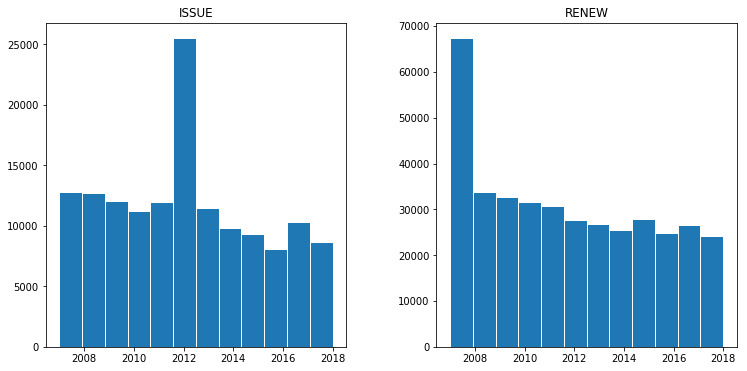

In [79]:
df \
    .loc[(df['APPLICATION TYPE'] == 'ISSUE') | (df['APPLICATION TYPE'] == 'RENEW')] \
    .loc[df['YEAR'] >= 2007] \
    [['APPLICATION TYPE', 'YEAR']] \
    .hist(by='APPLICATION TYPE',
          grid=False,
          bins=df['YEAR'].max() - 2007 + 1,
          figsize=(12,6),
          xrot=360,
          edgecolor="white")

plt.savefig('plots/licenses_by_type_year.png')

### Number of business nonrenewals by year

In [77]:
base = reshape_and_create_label(df)

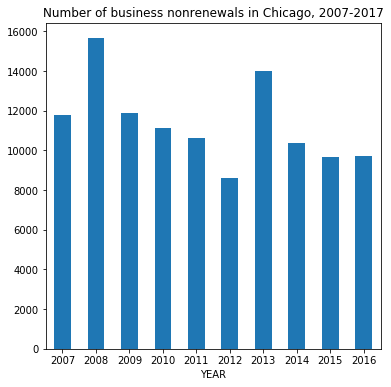

In [78]:
# Number of nonrenewals by year
base \
    .loc[base['not_renewed_2yrs'] == 1] \
    .loc[base['YEAR'] >= 2007] \
    .groupby('YEAR') \
    .size() \
    .plot.bar(title='Number of business nonrenewals in Chicago, 2007-2017',
              figsize=(6,6), 
              rot=360)

plt.savefig('plots/fails_by_year.png')

### Number of nonrenewals by Business Category

In [236]:
# Get df of business category by account-site
activity_df = df[['ACCOUNT NUMBER', 'SITE NUMBER', 'BUSINESS ACTIVITY']] \
    .dropna(subset=['BUSINESS ACTIVITY']) \
    .drop_duplicates() \
    .sort_values(by=['ACCOUNT NUMBER', 'SITE NUMBER'])

activity_df.head(10)

,ACCOUNT NUMBER,SITE NUMBER,BUSINESS ACTIVITY
156224,1,1,Retail Sale of Tobacco
708461,1,1,Retail Sales of Perishable Foods
737469,1,1,Consumption of Liquor on Premises
26538,1,2,Preparation of Food and Dining on Premise With...
26554,1,2,Consumption of Liquor on Premises
397953,2,2,Consumption of Liquor on Premises
398259,2,2,Retail Sales of Perishable Foods
701027,4,1,Retail Sales of Perishable Foods
963804,4,1,Tavern - Consumption of Liquor on Premise
714842,6,1,Retail Sales of Perishable Foods


In [250]:
activity_count = base.loc[base['not_renewed_2yrs'] == 1] \
    .merge(activity_df,
           how='left',
           on=['ACCOUNT NUMBER', 'SITE NUMBER']) \
    .groupby('BUSINESS ACTIVITY') \
    .size() \
    .sort_values(ascending=False) \
    .reset_index() \
    .rename({0: 'count'}, axis=1)

activity_count['pct'] = activity_count['count'] / activity_count['count'].sum() * 100
activity_count.head(10)

,BUSINESS ACTIVITY,count,pct
0,Retail Sales of Perishable Foods,19179,26.847432
1,Special Event Food,8831,12.361941
2,Retail Sale of Tobacco,6136,8.589386
3,Other Home Occupations,2426,3.395999
4,"Peddler- Retail Sales of General Merchandise, ...",1961,2.745076
5,Consumption of Liquor on Premises,1950,2.729678
6,Home Repair Services,1799,2.518303
7,Special Event Beer & Wine,1629,2.280331
8,"Street Performer, Moving Along the Public Way",1445,2.022761
9,Wholesale Food Sales,1019,1.426432


### Number of nonrenewals by Census tract in 2016

In [197]:
# Get tract GEOIDs for all businesses
bus_tracts = pd.read_csv('../../data/business_licenses_with_tracts.csv')
bus_tracts.head()

,Unnamed: 0,LICENSE ID,LICENSE NU,LEGAL NAME,ACCOUNT NU,SITE NUMBE,ADDRESS,CITY,STATE,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,DATE ISSUE,GEOID_2010,GEOID_2000,geometry
0,0,1723393,22308.0,BELL OIL TERMINAL INC,29481,1,3741 S PULASKI RD 1,CHICAGO,IL,60623.0,41.82532,-87.72396,"(41.82531992987547, -87.72395999659746)",08/11/2006,170318305003,170313020003,POINT (-87.72395999700001 41.82531993)
1,1,1479006,22308.0,BELL OIL TERMINAL INC,29481,1,3741 S PULASKI RD 1,CHICAGO,IL,60623.0,41.82532,-87.72396,"(41.82531992987547, -87.72395999659746)",04/16/2004,170318305003,170313020003,POINT (-87.72395999700001 41.82531993)
2,2,1151715,22308.0,BELL OIL TERMINAL INC,29481,1,3741 S PULASKI RD 1,CHICAGO,IL,60623.0,41.82532,-87.72396,"(41.82531992987547, -87.72395999659746)",03/05/2004,170318305003,170313020003,POINT (-87.72395999700001 41.82531993)
3,3,1827754,22308.0,BELL OIL TERMINAL INC,29481,1,3741 S PULASKI RD 1,CHICAGO,IL,60623.0,41.82532,-87.72396,"(41.82531992987547, -87.72395999659746)",07/25/2007,170318305003,170313020003,POINT (-87.72395999700001 41.82531993)
4,4,1479004,22308.0,BELL OIL TERMINAL INC,29481,1,3741 S PULASKI RD 1,CHICAGO,IL,60623.0,41.82532,-87.72396,"(41.82531992987547, -87.72395999659746)",03/05/2004,170318305003,170313020003,POINT (-87.72395999700001 41.82531993)


In [205]:
bus_tracts = pd.read_csv('../../data/business_licenses_with_tracts.csv')

bus_tracts = bus_tracts[['ACCOUNT NU', 'SITE NUMBE', 'GEOID_2010']] \
    .dropna() \
    .drop_duplicates() \
    .sort_values(by=['ACCOUNT NU', 'SITE NUMBE']) \
    .rename({
        'ACCOUNT NU': 'ACCOUNT NUMBER', 
        'SITE NUMBE': 'SITE NUMBER'
    }, axis=1)

bus_tracts['GEOID_2010'] = bus_tracts['GEOID_2010'].astype('str').str.slice(0, 11)
# bus_tracts['GEOID_2010'] = bus_tracts['GEOID_2010'].apply(lambda x: x + '00')

bus_tracts.head()

,ACCOUNT NUMBER,SITE NUMBER,GEOID_2010
61875,1,1,17031839100
60863,1,2,17031839100
378753,2,2,17031770602
385400,4,1,17031062900
546880,6,1,17031839900


In [199]:
# read shapefile
TRACT_PATH = 'Boundaries - Census Tracts - 2010.geojson'
tract_gdf = gpd.read_file(TRACT_PATH)
tract_gdf['geoid10'] = tract_gdf['geoid10'].astype('str')
tract_gdf.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...


In [220]:
fails_2016_geo = gpd.GeoDataFrame(
    base \
    .loc[base['YEAR'] == 2016] \
    .loc[base['not_renewed_2yrs'] == 1] \
    .merge(bus_tracts,
           how='left',
           on=['ACCOUNT NUMBER', 'SITE NUMBER']) \
    .groupby('GEOID_2010') \
    .size() \
    .reset_index() \
    .rename({0: 'count'}, axis=1) \
    .merge(tract_gdf[['geoid10', 'geometry']],
           how='left',
           left_on='GEOID_2010',
           right_on='geoid10')
    ) \
    .drop('geoid10', axis=1) \
    .sort_values(by='count', ascending=False)

fails_2016_geo.head()

,GEOID_2010,count,geometry
738,17031839100,348,(POLYGON ((-87.63581300003786 41.8873780000147...
383,17031320100,150,(POLYGON ((-87.61343799999288 41.8878870000046...
696,17031833000,123,(POLYGON ((-87.65203100003609 41.8817000000025...
141,17031081800,118,(POLYGON ((-87.63544499995751 41.8874249999631...
138,17031081500,112,(POLYGON ((-87.62684999998037 41.8966949999996...


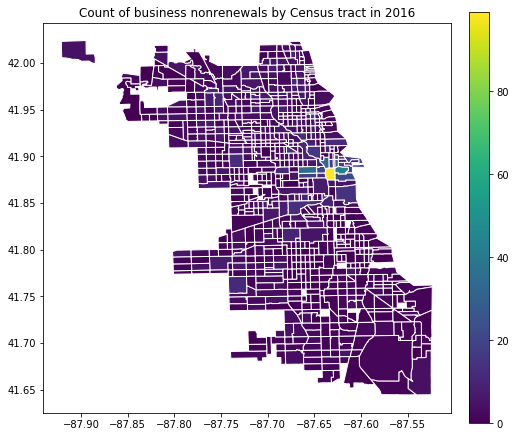

In [234]:
ax = fails_2016_geo.plot(column='count',
                    figsize=(8,8),
                    edgecolor='white')

ax.set_title('Count of business nonrenewals by Census tract in 2016')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.savefig('plots/fails_by_tract.png')